# **Interpretable AI For Protein Expression Images and Associated Clinical Metadata (Grad-CAM_VGG16(Single Channel Protein Images((SDHA)))**

## **1. Introduction**

With a conservative frequency estimate of about 1:5,000, mitochondrial disorders are among the most prevalent inheritable diseases [1]. Diagnosis and understanding of the different mitochondrial diseases are extremely difficult because they have a wide range of symptoms in each patient and affect different organs and tissues of the body [2]. However, recent studies show deep learning algorithms with interpretability and explainability, especially Convolutional Neural Networks (CNN), can help us automatically diagnose and evaluate different diseases by detecting the different patterns in the images. In the study, we developed deep learning models using transfer learning to predict mitochondrial diseases and used existing machine learning interpretability and explainability AI approaches for computer vision, like Grad-CAM [3], and Neural Disentanglement (concept whitening) [4], to understand the features that result in the prediction of mitochondrial disease from protein expression images.

## **2. Aim**

To determine if Deep Learning (DL) can be used as a reliable method to classify mitochondrial diseases using interpretability
and explainability approaches.

• Interpretability Method: Neural Disentanglement

• Explainability Method: Saliency Map 

## **3. Objective**

This investigation has primarily two objectives:

3.1. Determine whether it is possible to accurately diagnose mitochondrial diseases for single channel protein images.

>  Adapt the pre-trained deep learning models like VGG16 and ResNet-50 to classify different mitochondrial diseases using protein expression images obtained by image mass cytometry. Evaluate, compare, and fine-tune different pre-trained model architectures using parameters like accuracy, precision, recall, f1 score, and confusion matrix.

3.2. Understand the underlying pathology of mitochondrial diseases.

> Once we know that the pre-trained deep learning models are able to classify different mitochondrial diseases, we can make then apply different interpretability and explainability AI approaches such as Grad-CAM and Neural Disentanglement on top of the pre-train models to understand the underlying pathology of mitochondrial diseases. 

#**Importing essential libraries**

In [1]:
# initiating gpu using tensorflow.
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import tensorflow as tf 

import numpy as np
import pandas as pd
import glob
import random 
import os
import cv2
from shutil import copy,copytree
import shutil

!pip install patchify
from patchify import patchify

from google.colab import files
import os
import zipfile

#visulaziation
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


# image
from PIL import Image

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet101V2, Xception, ResNet50V2, VGG19
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#setting seed to reproduce the same result every time the code is re-run
seed_num = 1
tf.random.set_seed(seed_num)
np.random.seed(seed_num)

# install split-folder
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unziping the dataset**

In [4]:
%%capture
!unzip /content/drive/MyDrive/Dataset.zip

#**Data Engineering**

Renaming all the files in the subfolder for both control and patient with subfolder names

In [5]:
d = ["/content/Dataset/controls/C01","/content/Dataset/controls/C02","/content/Dataset/controls/C03","/content/Dataset/controls/C04"]
for i in d:
  for path in os.listdir(i):
      full_path = os.path.join(i, path)
      if os.path.isfile(full_path):
          new_path = os.path.join(i, "C0"+str(d.index(i)+1)+"_"+ path)
          os.rename(full_path, new_path)

In [6]:
d = ["/content/Dataset/patients/P01","/content/Dataset/patients/P02","/content/Dataset/patients/P03","/content/Dataset/patients/P04","/content/Dataset/patients/P05","/content/Dataset/patients/P06","/content/Dataset/patients/P07","/content/Dataset/patients/P08","/content/Dataset/patients/P09","/content/Dataset/patients/P10"]
for i in d:
  for path in os.listdir(i):
      full_path = os.path.join(i, path)
      if os.path.isfile(full_path):
          new_path = os.path.join(i, "P0"+str(d.index(i)+1)+"_" + path)
          os.rename(full_path, new_path)

**Copying all the JPG images into Dataset_JPG directory and maintaing the tree structure of the directories**

In [7]:
shutil.copytree('/content/Dataset', '/content/Dataset_JPG' , ignore=shutil.ignore_patterns('*.ome.tiff', '*.db'))

'/content/Dataset_JPG'

**Copying all the TIFF images into Dataset_TIFF directory and maintaing the tree structure of the directories**

In [8]:
shutil.copytree('/content/Dataset', '/content/Dataset_TIFF' , ignore=shutil.ignore_patterns('*.jpg', '*.db'))

'/content/Dataset_TIFF'

#**Single Protein Images**

In the analysis we are taking only one single protein images(SDHA) out of 10 of 10 different protein images from controls and patients images into respective single Controls and Patients SDHA Image folder.


In [9]:
#Creating a new path to store all jpg images(Control SDHA Images)
newpath = r'/content/SDHA_Images/Controls' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
dir_src = r"/content/Dataset_JPG/controls"
dir_dst = r"/content/SDHA_Images/Controls"
for file in glob.iglob('%s/**/*SDHA.jpg' % dir_src, recursive=True):
    copy(file, dir_dst)

In [10]:
#Creating a new path to store all jpg images(Patients SDHA Images)
newpath = r'/content/SDHA_Images/Patients' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
dir_src = r"/content/Dataset_JPG/patients"
dir_dst = r"/content/SDHA_Images/Patients"
for file in glob.iglob('%s/**/*SDHA.jpg' % dir_src, recursive=True):
    copy(file, dir_dst)

**Spliting the image into sub-images using patchify function**

**For Control:**

In [11]:
#Creating a new path to store all spliting jpg images(Control SDHA Images)
newpath = r'/content/SDHA_Split_Images/Controls' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
my_path = "/content/SDHA_Images/Controls"
files = glob.glob(my_path + '/**/*.jpg', recursive=True)
for file in files:
  img = cv2.imread(file)
  patches_img = patchify(img, (512,512,3), step=224)
  for i in range(patches_img.shape[0]):
      for j in range(patches_img.shape[1]):
          single_patch_img = patches_img[i, j, 0,:, :, :]
          cv2.imwrite(r'/content/SDHA_Split_Images/Controls/' + "C0"+str(files.index(file)+1)+'_image_' + '_'+ str(i)+str(j)+'.jpg', single_patch_img)

**For Patient:**

In [12]:
#Creating a new path to store all spliting jpg images(Control SDHA Images)
newpath = r'/content/SDHA_Split_Images/Patients' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
my_path = "/content/SDHA_Images/Patients"
files = glob.glob(my_path + '/**/*.jpg', recursive=True)
for file in files:
  img = cv2.imread(file)
  patches_img = patchify(img, (512,512,3), step=224)
  for i in range(patches_img.shape[0]):
      for j in range(patches_img.shape[1]):
          single_patch_img = patches_img[i, j, 0, :, :, :]
          cv2.imwrite(r'/content/SDHA_Split_Images/Patients/' + "P0"+str(files.index(file)+1)+'_image_' + '_'+ str(i)+str(j)+'.jpg', single_patch_img)
              

In [13]:
image_dir = Path('/content/SDHA_Split_Images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [14]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/content/SDHA_Split_Images/Patients/P010_image...,Patients
1,/content/SDHA_Split_Images/Patients/P07_image_...,Patients
2,/content/SDHA_Split_Images/Patients/P03_image_...,Patients
3,/content/SDHA_Split_Images/Patients/P09_image_...,Patients
4,/content/SDHA_Split_Images/Patients/P02_image_...,Patients


**Overview of images:**

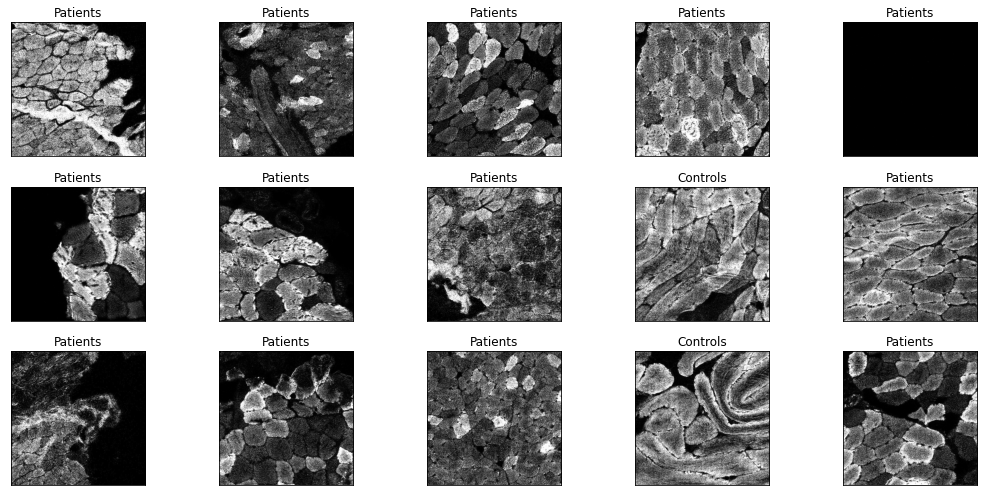

In [15]:
# Display 20 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

**Load the Images with a generator**

In [16]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [17]:
# Separate in train and test data
train_df, val_df = train_test_split(train_df, train_size=0.9, shuffle=True, random_state=1)

In [66]:
train_datagen=ImageDataGenerator(rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)
val_datagen=ImageDataGenerator(rescale = 1./255)
test_datagen=ImageDataGenerator(rescale = 1./255)

In [19]:
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=True,
    seed=42,
    subset='training'
)
val_images = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

Found 982 validated image filenames belonging to 2 classes.
Found 110 validated image filenames belonging to 2 classes.
Found 122 validated image filenames belonging to 2 classes.


In [20]:
# Load the pretained model
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [21]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [64]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(2048, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='softmax')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

optim=Adam(learning_rate=0.001)
model.compile(
    optimizer=optim,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
model.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [24]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=30,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
491/491 [==============================] - 23s 24ms/step - loss: 0.3336 - accuracy: 0.8676 - val_loss: 0.2383 - val_accuracy: 0.9091
Epoch 2/100
491/491 [==============================] - 11s 23ms/step - loss: 0.1976 - accuracy: 0.9318 - val_loss: 0.3289 - val_accuracy: 0.8727
Epoch 3/100
491/491 [==============================] - 11s 23ms/step - loss: 0.1487 - accuracy: 0.9430 - val_loss: 0.1040 - val_accuracy: 0.9545
Epoch 4/100
491/491 [==============================] - 11s 23ms/step - loss: 0.1105 - accuracy: 0.9572 - val_loss: 0.1299 - val_accuracy: 0.9364
Epoch 5/100
491/491 [==============================] - 11s 23ms/step - loss: 0.1014 - accuracy: 0.9674 - val_loss: 0.0516 - val_accuracy: 0.9909
Epoch 6/100
491/491 [==============================] - 12s 24ms/step - loss: 0.1018 - accuracy: 0.9633 - val_loss: 0.1556 - val_accuracy: 0.9273
Epoch 7/100
491/491 [==============================] - 11s 23ms/step - loss: 0.0952 - accuracy: 0.9664 - val_loss: 0.0969 - val_ac

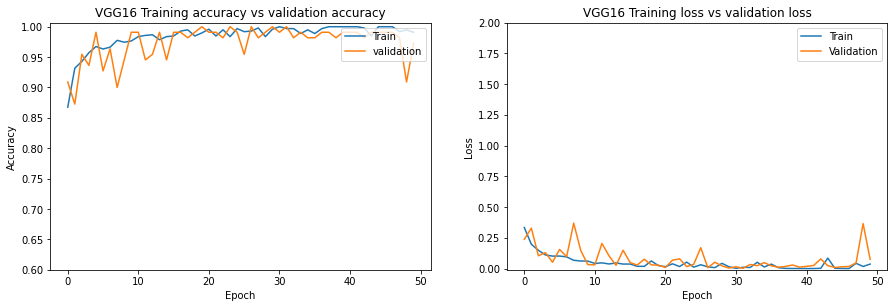

In [25]:
# Plot training & validation accuracy values
plt.figure(1, figsize = (15,10)) 
plt.subplot(221) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Training accuracy vs validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim((0.6))
plt.legend(['Train', 'validation'], loc='upper right')

# Plot training & validation loss values
plt.subplot(222) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Training loss vs validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((-0.01,2))
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#**Visualize the result**

In [26]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.07199
Test Accuracy: 97.54%


###**Saving the model:**

In [31]:
model.save('/content/drive/MyDrive/GRAD_CAM_Single_Protein(SDHA)/VGG16_GRAD_CAM_SDHA_Protein.h5')
print("saved the model")

saved the model


##**Classification report**

In [33]:
# Predict the label of the test_images
pred = model_loaded.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [34]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    Controls       0.94      0.97      0.96        33
    Patients       0.99      0.98      0.98        89

    accuracy                           0.98       122
   macro avg       0.96      0.97      0.97       122
weighted avg       0.98      0.98      0.98       122



##**Confusion Matrix**

In [35]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, pred)

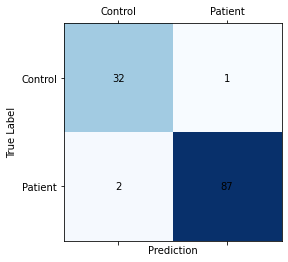

<Figure size 1080x720 with 0 Axes>

In [36]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Blues)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Control', 'Patient']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.figure(figsize=(15,10))
plt.show()

**Examples of Prediction**

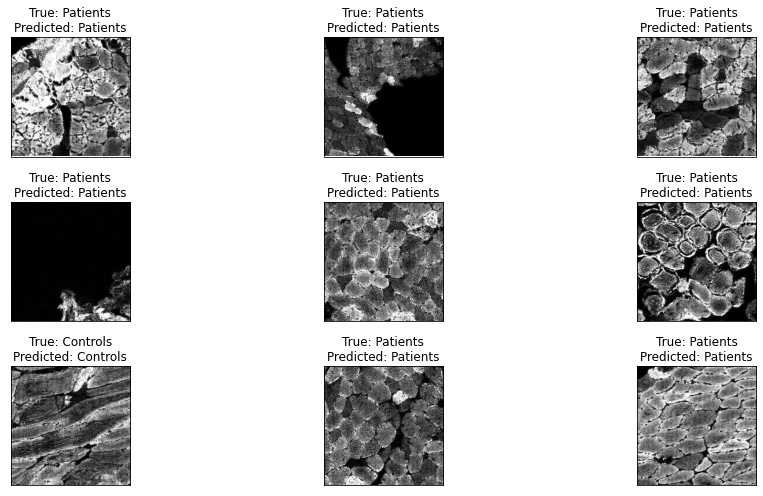

In [37]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

#**Class activation heatmap for image classification**

**Grad-CAM class activation visualization**

In [89]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)/255
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
#preprocess_input = tf.keras.applications.VGG16.preprocess_input
#decode_predictions = tf.keras.applications.VGG16.decode_predictions

last_conv_layer_name = "block5_conv3"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

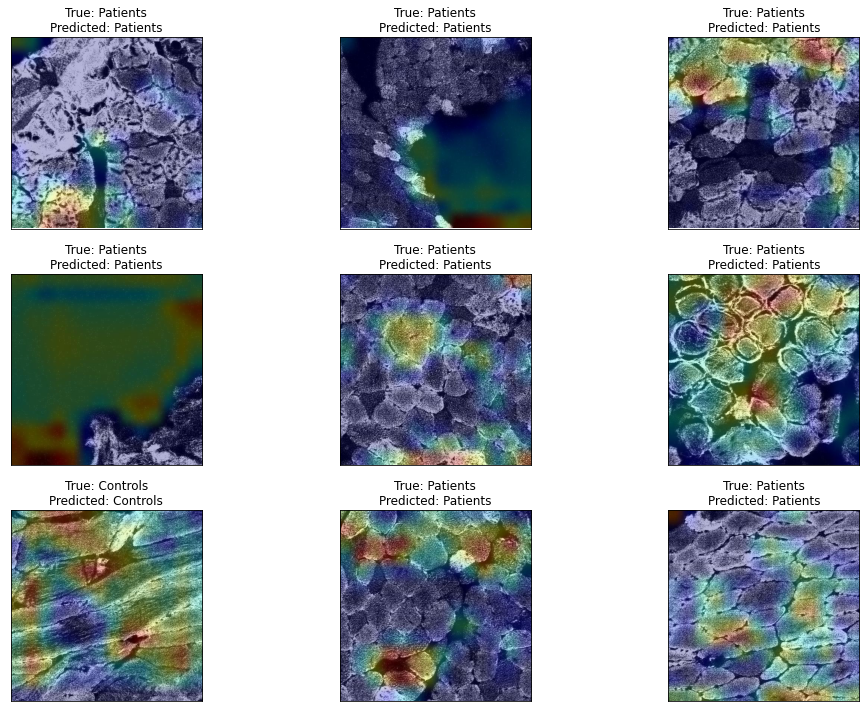

In [39]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = get_img_array(img_path, size=img_size)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

##**Prediction on Random Images**

###**Load model for prediction**


In [81]:
model_loaded = load_model("/content/drive/MyDrive/GRAD_CAM_Single_Protein(SDHA)/VGG16_GRAD_CAM_SDHA_Protein.h5")

**For control**

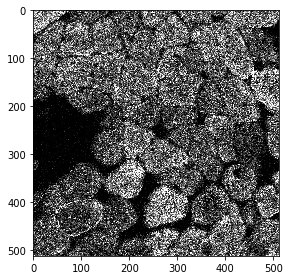

In [90]:
from skimage import io
image_path='/content/drive/MyDrive/GRAD_CAM_Single_Protein(SDHA)/Testing/C02_image__60.jpg' 
img = io.imread(image_path)
io.imshow(img)


Control


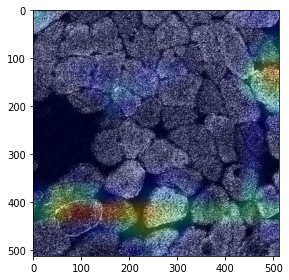

In [91]:
img_array = get_img_array(image_path, size=img_size)
answer = model_loaded.predict(img_array)
predit = np.argmax(answer,axis=1)
if predit==0:
  print('Control')
else:
  print('Patient')
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
cam_path = save_and_display_gradcam(image_path, heatmap)
plt.imshow(plt.imread(cam_path))
plt.tight_layout()
plt.show()

**For Patient**

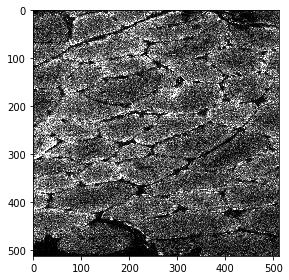

In [92]:
from skimage import io
image_path='/content/drive/MyDrive/GRAD_CAM_Single_Protein(SDHA)/Testing/P01_image__96.jpg' 
img = io.imread(image_path)
io.imshow(img)

Patient


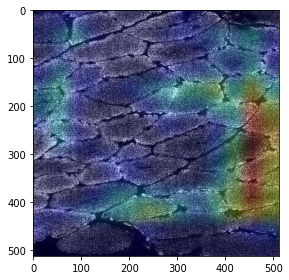

In [93]:
img_array = get_img_array(image_path, size=img_size)
answer = model_loaded.predict(img_array)
predit = np.argmax(answer,axis=1)
if predit==0:
  print('Control')
else:
  print('Patient')
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
cam_path = save_and_display_gradcam(image_path, heatmap)
plt.imshow(plt.imread(cam_path))
plt.tight_layout()
plt.show()

#**Reference**

1. Gorman, A. M. Schaefer, Y. Ng, N. Gomez, and Blakely, “Prevalence of nuclear and mitochondrial DNA mutations related to adult mitochondrial disease,” Annals of Neurology, vol. 77. Wiley Online Library, pp. 753–759, 2015.
2. P. Forny, E. Footitt, J. E. Davison, A. Lam, and Woodward, “Diagnosing mitochondrial disorders remains challenging in the omics era,” Neurology. Genetics, vol. 7. p. e597, 2021. doi:10.1212/NXG.0000000000000597.
3. LR. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh, and D. Batra, “GradCAM: Visualexplanations from deep networks via gradient-based localization,” International journal of computer vision, vol. 128. pp. 336–359, 2020. doi: 10.1007/s11263-019-01228-7.
4. Z. Chen, Y. Bei, and C. Rudin, “Concept whitening for interpretable image recognition,” NatureMachine Intelligence, vol. 2, no. 12, pp. 772–782, 2020, doi: 10.1038/s42256-02000265-z.

**Thank You!**